In [201]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

from numpy.linalg import norm

from utility_funcs import *

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

- В склерне оптимальные параметры ядра ищутся не градиентным спуском, а в gpytorch градиентным спуском как внутри pytorch - в этом главное отличие 

- Лосс, который пишется у гпр - это -log likelyhood loss для параметров, которые мы обучаем

- Мы добавляем какие-то параметры, чтобы не делать операции $O(N^3)$, а сделать несколько шагов оптимизации параметров вместе того, чтобы полностью точно считать обратную к K

- в склерне дефолтный кернел - это конст кернел * RBF - короче там 2 параметра обучается

In [202]:
MODE

'movements'

In [203]:
path = './dataset_objects/' + MODE + '/2_dataset_K_3.pt'        # ЗДЕСЬ БЫЛО МОДЕ ВМЕСТО movements

In [204]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = int(path.split("/")[-1].split('_')[0])     # число атомов
    K = int(path.split("/")[-1].split('_')[-1].split('.')[0])     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()
    p = np.random.uniform(low=1, high=3, size=K).copy()
    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 1024

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 5    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = L     # Если вдруг очень большие расстояния, то надо выкидывать
    f_min_threshold = 0.05
    #
    output_size = K     # Размерность аутпута модели

In [205]:
def make_predictions_and_check_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    Качество

    '''

    if data:
        X_matrices, Y_target, *_ = list(map(lambda x: torch.stack(x), list(zip(*data))))

        
    Y_pred = model.predict(X_matrices)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = mean_squared_error(Y_pred, Y_target)

    print(metric)

    return Ys

In [206]:
def formate_data_for_sklearn(data, size_cut=1):

    X = [elem[0].detach().numpy() for elem in data[:len(data) * size_cut]]
    Y = [elem[1].detach().numpy() for elem in data[:len(data) * size_cut]]

    X = np.stack(X)
    Y = np.stack(Y)
    return X, Y

In [207]:
my_kernel = ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) * RBF(1., length_scale_bounds="fixed")  # пока фиксированные параметры
my_kernel

1**2 * RBF(length_scale=1)

In [208]:
data = torch.load(path)

In [209]:
train_data, val_data, *_ = recieve_loaders(
    path=path,
    # take_one_projection_for_data=0
)       # in sklearn it is not learning in batches, so batch_size is not needed here

In [210]:
train_X, train_Y = formate_data_for_sklearn(train_data)
val_X, val_Y = formate_data_for_sklearn(val_data)

In [211]:
# normer = Normalizer()
# train_X = normer.fit_transform(train_X)
# val_X = normer.transform(val_X)

n_restarts_optimizer - если вдруг может быть несколько оптимумов чтобы несколько раз запустилось и попрбовало найти типо их несколько раз

- Что вообще оптимизируется - поскольку единственная случайно выбранная нами здесь вещь - это функция ядра, то мы как раз и оптимизируем параметры внутри этой функции ядра так, чтобы
мы получали ответы максимально близкие к таргетам. Она оптммизируется путем максимизации минус логарифма правдоподобия для данного параметра при условии данных

In [212]:
gpr = GaussianProcessRegressor(
    kernel=my_kernel,
    random_state=0,
    n_restarts_optimizer=1,
    normalize_y=True
    )

gpr.fit(train_X, train_Y)

Y_pred = gpr.predict(val_X, return_std=False)

In [213]:
mean_squared_error(val_Y, Y_pred)

1.6693104083205485e-11

In [214]:
gpr.score(val_X, val_Y)

0.9945439271662302

In [215]:
make_predictions_and_check_quality(model=gpr, data=val_data, same_axis=False)
None

1.6693104083205485e-11


In [216]:
gpr.kernel.get_params()

{'k1': 1**2,
 'k2': RBF(length_scale=1),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 1.0,
 'k2__length_scale_bounds': 'fixed'}

---
Снизу попытки что-то визуализировать:

In [217]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

In [218]:
Y_true = val_Y
Y_pred = gpr.predict(val_X)

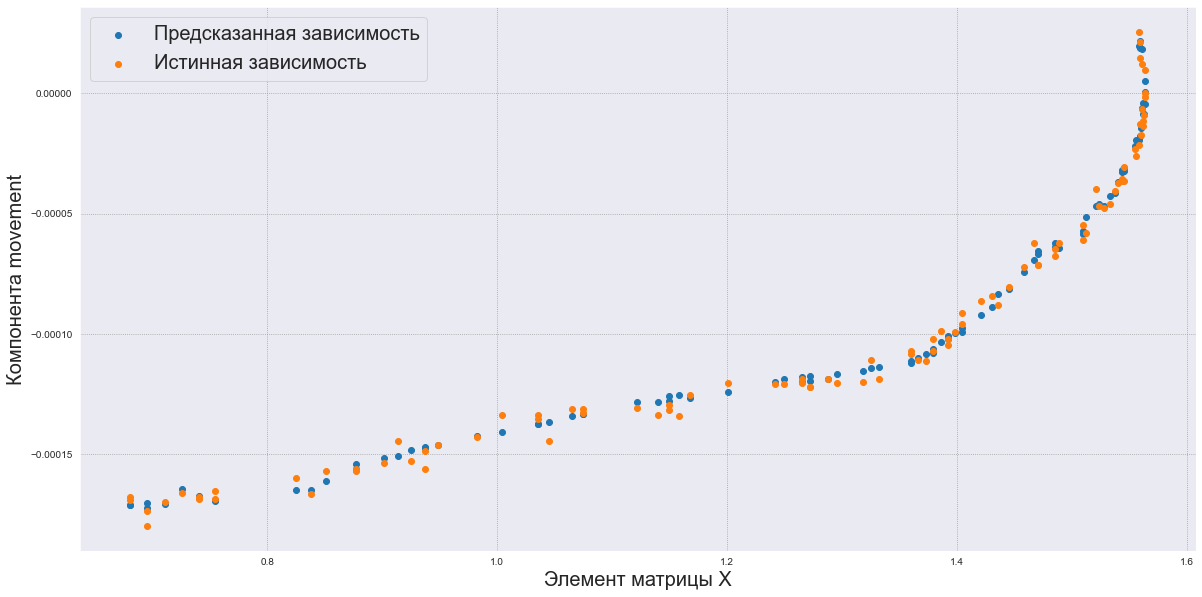

In [219]:
plot_2d_result(
    x11_val,
    y_pred=Y_pred if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_pred],
    y_true=Y_true if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_true],
    figsize=(20, 10)
)

- типо 4 полосочки потому что 4 частицы

Умные слова что с экспонентой нельзя....

Это типо не просто вектора V_i - это буквально силы...

ValueError: cannot reshape array of size 12 into shape (3,3)

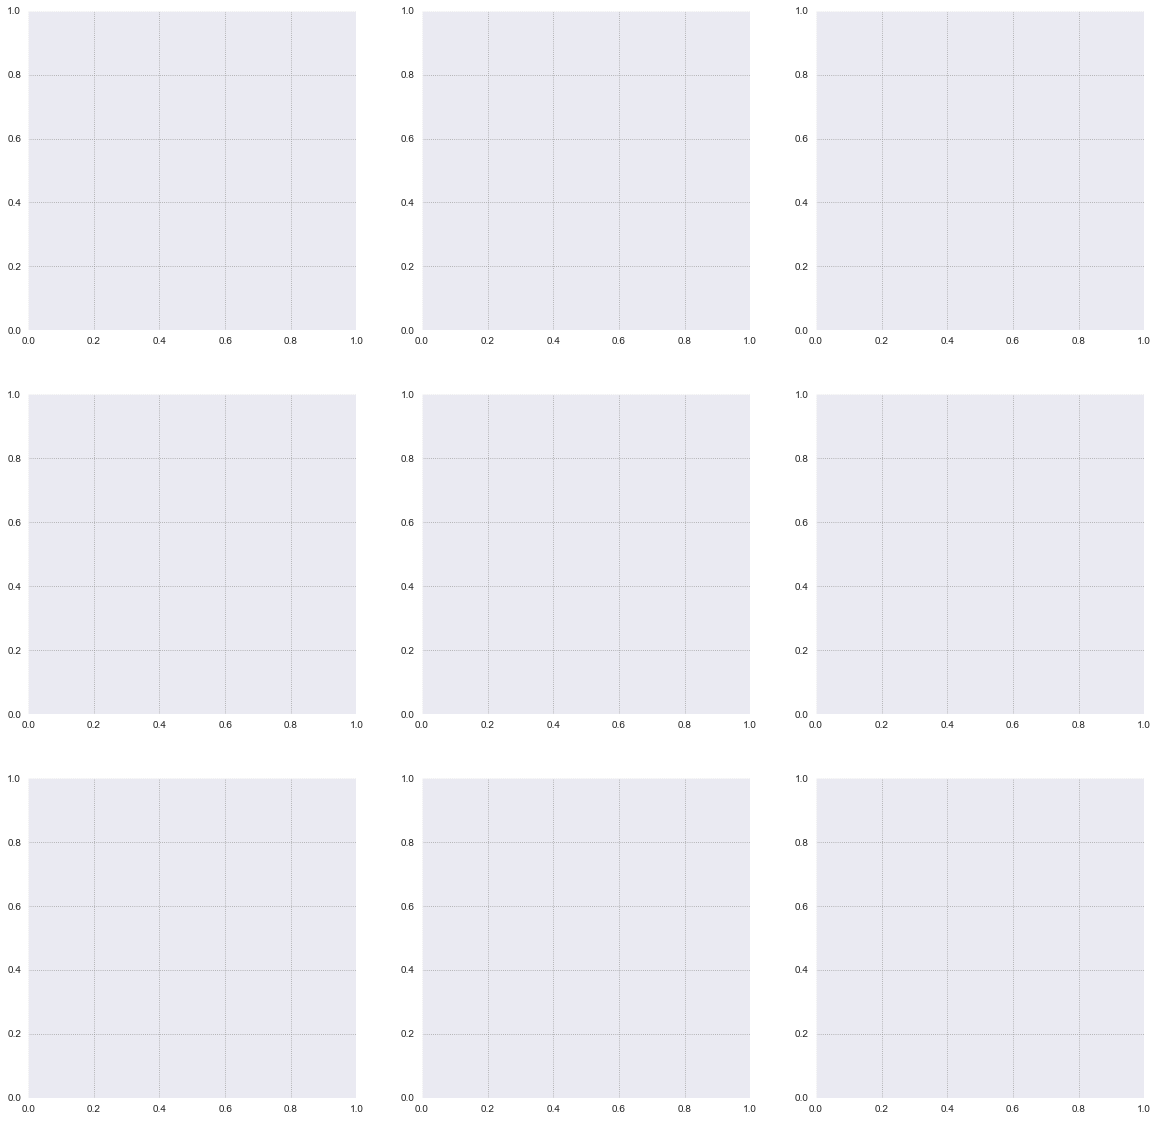

In [220]:
def plot_matrix(X, Y_pred, Y_true, figsize=(15, 15)):
    '''
    Function which plots matrix of dependencies: f_i(X_jj)
    '''
    k = len(Y_pred[0])
    fig, axes = plt.subplots(k, k, figsize=figsize)

    for i in range(k):  # цикл по компонентам силы
        y_pred = [elem[i] for elem in Y_pred]
        y_true = [elem[i] for elem in Y_true]
        for j in range(k):
            x = [elem.reshape(CFG.K, CFG.K)[j][j] for elem in X]
            axes[i][j].set_title(f'$f_{i}(X_{str(j)})$')
            axes[i][j].scatter(x, y_pred, label="Predicted", s=10)
            axes[i][j].scatter(x, y_true, label="True", s=10)
            axes[i][j].legend(loc="best")

plot_matrix(
    X=val_X,
    Y_pred=Y_pred,
    Y_true=Y_true,

    figsize=(20, 20)
)